In [51]:
import rasterio
import rasterio.plot
from rasterio.crs import CRS
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

# example


In [52]:
x = np.linspace(-4.0, 4.0, 240)
y = np.linspace(-3.0, 3.0, 180)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-2 * np.log(2) * ((X + 1) ** 2 + (Y) ** 2) / 1**2)
Z2 = np.exp(-2 * np.log(2) * ((X - 1) ** 2 + (Y) ** 2) / 1**2)

Z = (90 * Z2 + 5 * Z1) / (Z2 + Z1)
Zn = [Z1, Z2]
Z = np.sum([a*b for a,b in zip(Zn, [5, 90])], axis=0) / np.sum(Zn, axis=0)

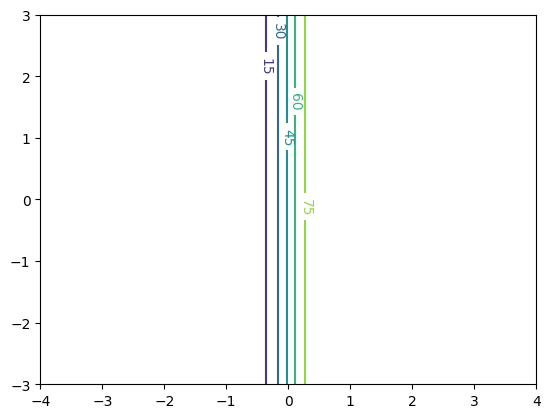

In [53]:
p = plt.contour(X, Y, Z)
plt.clabel(p, inline=1, fontsize=10)
plt.show()

In [54]:
# from rasterio.transform import Affine

# res = (x[-1] - x[0]) / 240.0
# transform = Affine.translation(x[0] - res / 2, y[0] - res / 2) * Affine.scale(res, res)
# transform

dkm


In [55]:
with rasterio.open(
    "new.tif",
    "w",
    driver="GTiff",
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
) as dst:
    dst.write(Z, 1)

/home/till/projects/map/env/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


/home/till/projects/map/env/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


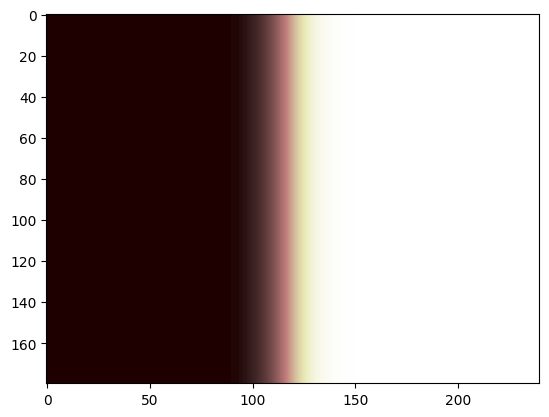

In [56]:
src = rasterio.open("new.tif")
plt.imshow(src.read(1), cmap='pink')
plt.show()

# real


In [57]:
points = gpd.read_file('../waiting_time_per_point.csv')
points.wait = points.wait.astype(float)
points.lat = points.lat.astype(float)
points.lon = points.lon.astype(float)
points = points[points['wait'] <= 100]

In [58]:
germany = [5.0, 48.0, 15.0, 55.0]
europe = [-12.0, 35.0, 45.0, 71.0]
world = [-180.0, -90.0, 180.0, 90.0]
map = germany

In [59]:
points = points[points["lat"] > map[1]]
points = points[points["lat"] < map[3]]
points = points[points["lon"] > map[0]]
points = points[points["lon"] < map[2]]

In [60]:
DENSITY = 10
x_density = int((map[2] - map[0]) * DENSITY)
y_density = int(map[3] - map[1]) * DENSITY
x = np.linspace(map[0], map[2], x_density)
y = np.linspace(map[1],map[3], y_density)
X, Y = np.meshgrid(x, y)


def get_dist(lat, lon):
    return np.exp(-2 *np.log(2) * ((X - lon) ** 2 + (Y - lat) ** 2) / 1**2)


Zn = [
    get_dist(lat, lon)
    for lat, lon in zip(points.lat, points.lon)
]
Z = np.sum([a*b for a,b in zip(Zn, points.wait)], axis=0) / np.sum(Zn, axis=0)

In [107]:
from rasterio.transform import Affine

res = (x[-1] - x[0]) / x_density

upper_left_x = x[0] - res / 2
upper_left_y = y[0] - res / 2


transform = Affine.translation(upper_left_x, upper_left_y) * Affine.scale(-res, res)

from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint


bl = GroundControlPoint(0, 0, map[0], map[1])
tl = GroundControlPoint(y_density, 0, map[2], map[1])
tr = GroundControlPoint(y_density, x_density, map[2], map[3])
br = GroundControlPoint(0, x_density, map[0], map[3])
gcps = [br, tr, tl, bl]

transform = from_gcps(gcps)

In [76]:
transform

Affine(0.0, 0.14285714285714285, 5.0,
       0.07, 0.0, 48.0)

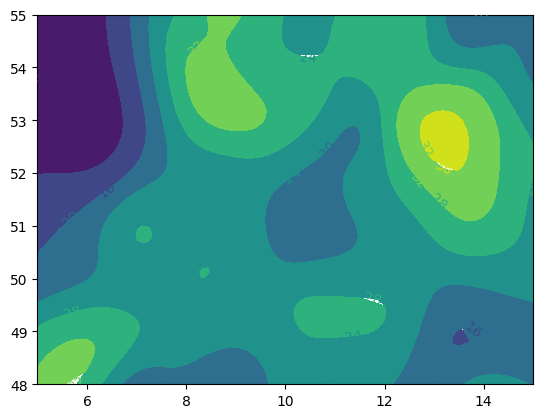

In [80]:
p = plt.contourf(X, Y, Z)
plt.clabel(p, inline=1, fontsize=10)
plt.show()

In [108]:
with rasterio.open(
    "map.tif",
    "w",
    driver="GTiff",
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    crs=CRS.from_epsg(4326),
    transform=transform,
    dtype=Z.dtype,
) as dst:
    dst.write(Z, 1)

In [64]:
countries.plot()

NameError: name 'countries' is not defined

/tmp/ipykernel_8023/2538347012.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/home/till/projects/map/env/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


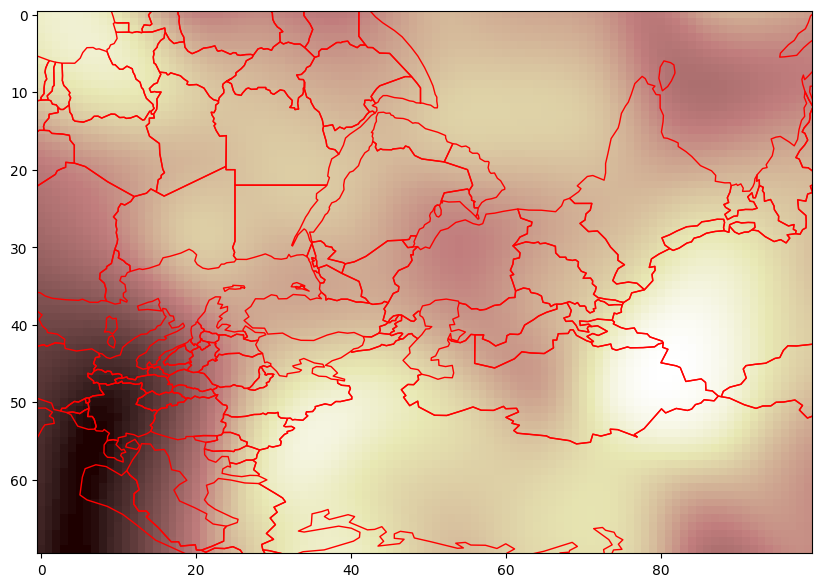

In [ ]:
countries = gpd.read_file("ROR5000.shp")
src = rasterio.open("german.tif")

fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(src, ax=ax)
countries.plot(ax=ax, facecolor='none', edgecolor='red')
plt.imshow(src.read(1), cmap='pink')
plt.show()

In [127]:
import matplotlib.colors as colors

cmap = colors.ListedColormap(['#008200', '#00c800','#00ff00', '#c8ff00', '#ffff00', '#ffc800', '#ff8200', '#ff0000', '#c80000', '#820000'])
boundaries = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

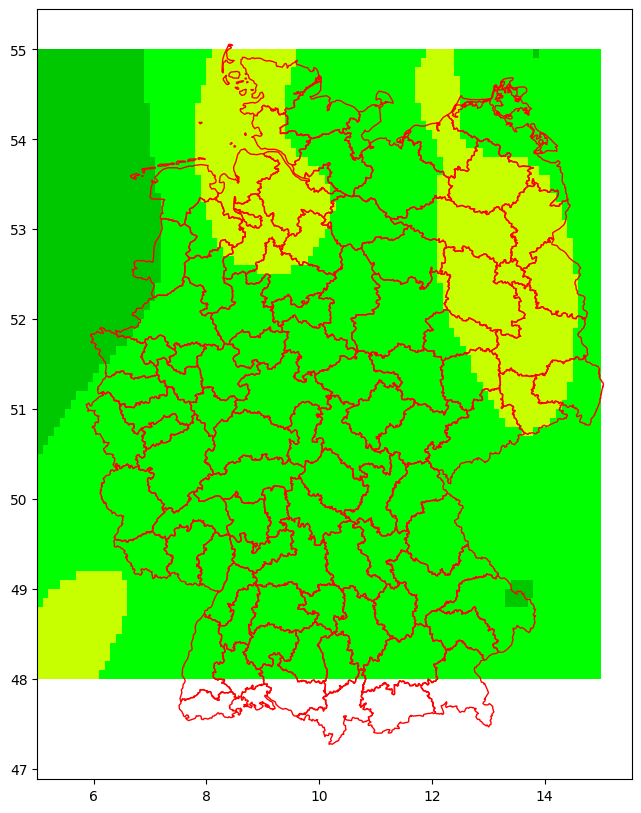

In [128]:
countries = gpd.read_file("german_shape/ROR5000.shp")
countries = countries.to_crs(epsg=4326)
raster = rasterio.open("map.tif")
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(raster, origin='lower', ax=ax, cmap=cmap, norm=norm)

countries.plot(ax=ax, facecolor='none', edgecolor='red')
plt.show()

In [117]:
countries = countries.to_crs(epsg=4326)

,SN_ROR,ROR,geometry
0,1001,Saar,"POLYGON ((7.10120 49.15546, 7.08114 49.14888, ..."
1,0101,Schleswig-Holstein Mitte,"POLYGON ((10.16900 54.43277, 10.18884 54.41156..."
2,0102,Schleswig-Holstein Nord,"MULTIPOLYGON (((8.70506 54.55753, 8.69654 54.5..."
3,0103,Schleswig-Holstein Ost,"MULTIPOLYGON (((10.58174 53.89670, 10.58265 53..."
4,0104,Schleswig-Holstein Süd,"MULTIPOLYGON (((10.23671 53.49621, 10.21829 53..."
...,...,...,...
91,0914,Oberpfalz-Nord,"POLYGON ((11.93618 49.21638, 11.92051 49.26295..."
92,0915,Regensburg,"POLYGON ((12.30894 49.15515, 12.31896 49.15919..."
93,0916,Südostoberbayern,"POLYGON ((12.70282 47.68164, 12.66683 47.68084..."
94,0917,Westmittelfranken,"POLYGON ((10.64207 49.01648, 10.62684 49.02057..."


In [118]:
countries

,SN_ROR,ROR,geometry
0,1001,Saar,"POLYGON ((3361573.349 5448212.036, 3360091.603..."
1,0101,Schleswig-Holstein Mitte,"POLYGON ((3575928.298 6034278.449, 3577255.666..."
2,0102,Schleswig-Holstein Nord,"MULTIPOLYGON (((3480988.554 6047574.296, 34804..."
3,0103,Schleswig-Holstein Ost,"MULTIPOLYGON (((3604046.596 5975139.361, 36040..."
4,0104,Schleswig-Holstein Süd,"MULTIPOLYGON (((3582143.142 5930117.467, 35809..."
...,...,...,...
91,0914,Oberpfalz-Nord,"POLYGON ((3713975.056 5457405.308, 3712633.750..."
92,0915,Regensburg,"POLYGON ((3741424.681 5451719.289, 3742135.375..."
93,0916,Südostoberbayern,"POLYGON ((3778079.508 5289238.830, 3775381.766..."
94,0917,Westmittelfranken,"POLYGON ((3620187.143 5432320.465, 3619062.955..."


Warning 1: TIFFFetchNormalTag:Incorrect value for "RichTIFFIPTC"; tag ignored


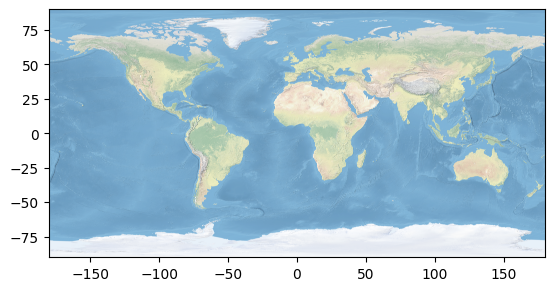

<Axes: >

In [ ]:
raster = rasterio.open("world.tif")
rasterio.plot.show(raster)